# 1. Imports

In [1]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# TorchVision (for image transforms, datasets and pretrained models)
from torchvision import datasets, transforms, models

# Numerics & utilities
import numpy as np
import os

# Metrics & evaluation
from sklearn.metrics import (
    confusion_matrix, 
    precision_recall_fscore_support, accuracy_score,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Progress bar
from tqdm import tqdm


# 2. Config

In [2]:
# Device Selection (GPU to MPS to CPU)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"   # for MacBook
else:
    DEVICE = "cpu"

# Hyperparameters 
BATCH_SIZE = 8
IMG_SIZE = 224       # standard for pretrained CNNs
EPOCHS = 15
LR = 0.0005          # good LR for fine tuning pretrained models

# Paths 
DATA_DIR = "../data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")

DEVICE


'cuda'

# 3. Dataset & Transforms

In [3]:
# Image Transforms

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.2
),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])  # ImageNet std
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Load Dataset

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR,   transform=val_transforms)

CLASS_NAMES = train_dataset.classes
print("Class order:", CLASS_NAMES)

# Show dataset sizes
len(train_dataset), len(val_dataset)


Class order: ['gum_inflammation', 'healthy', 'plaque', 'unknown']


(42, 8)

# 4. Dataloaders

In [4]:
# DataLoaders 

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

len(train_loader), len(val_loader)

(6, 1)

# 5. Model

In [5]:
# Load EfficientNet-B0 pretrained on ImageNet
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Replace the final classification layer
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 4)   # 4 classes: healthy, plaque, inflammation, unknown

model = model.to(DEVICE)

model


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# 6. Loss Function, Optimizer and Scheduler

In [6]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


criterion, optimizer


(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.0005
     lr: 0.0005
     maximize: False
     weight_decay: 0
 ))

# 7. Training Loop and Validation

In [7]:
# Training Function

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        
        # good practice
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item()
    
    return running_loss / len(loader)


# Validation Function

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    return running_loss / len(loader), accuracy, all_preds, all_labels

# Full Training Loop

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, DEVICE)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/15


Train Loss: 1.3138 | Val Loss: 1.1726 | Val Acc: 0.2500

Epoch 2/15


Train Loss: 1.0496 | Val Loss: 1.0593 | Val Acc: 0.7500

Epoch 3/15


Train Loss: 0.6530 | Val Loss: 0.9361 | Val Acc: 0.7500

Epoch 4/15


Train Loss: 0.6057 | Val Loss: 0.9117 | Val Acc: 0.6250

Epoch 5/15


Train Loss: 0.6052 | Val Loss: 1.1271 | Val Acc: 0.6250

Epoch 6/15


Train Loss: 0.6481 | Val Loss: 1.0362 | Val Acc: 0.6250

Epoch 7/15


Train Loss: 0.2549 | Val Loss: 1.0512 | Val Acc: 0.7500

Epoch 8/15


Train Loss: 0.3728 | Val Loss: 0.9901 | Val Acc: 0.8750

Epoch 9/15


Train Loss: 0.3539 | Val Loss: 0.9921 | Val Acc: 0.8750

Epoch 10/15


Train Loss: 0.2134 | Val Loss: 1.8080 | Val Acc: 0.5000

Epoch 11/15


Train Loss: 0.3704 | Val Loss: 1.4592 | Val Acc: 0.6250

Epoch 12/15


Train Loss: 0.1265 | Val Loss: 0.7757 | Val Acc: 0.8750

Epoch 13/15


Train Loss: 0.5712 | Val Loss: 0.7125 | Val Acc: 0.7500

Epoch 14/15


Train Loss: 0.1400 | Val Loss: 0.9091 | Val Acc: 0.7500

Epoch 15/15


Train Loss: 0.0552 | Val Loss: 1.3027 | Val Acc: 0.7500


# 7.5 Plot Training and Validation Losses 

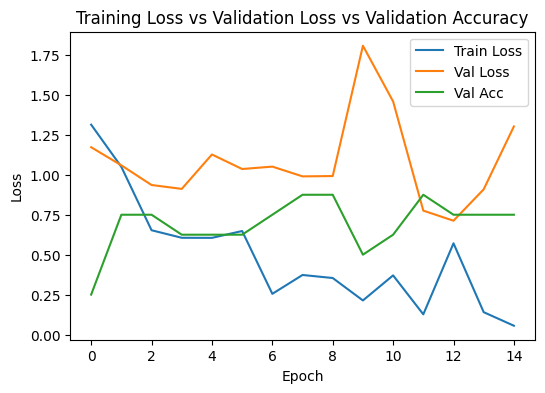

In [15]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(False)
plt.title("Training Loss vs Validation Loss vs Validation Accuracy")
plt.show()

# 8. Evaluation Metrics

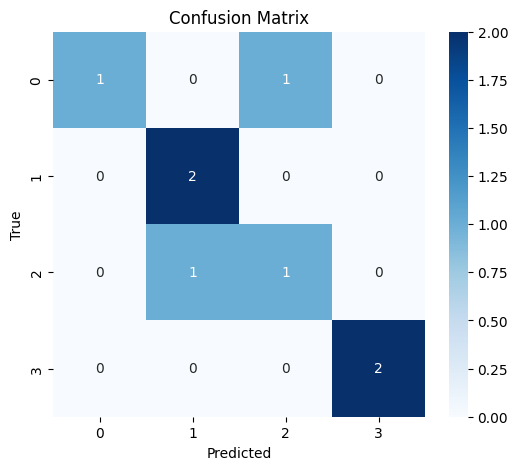

Precision per class: [1.         0.66666667 0.5        1.        ]
Recall per class: [0.5 1.  0.5 1. ]
F1 per class: [0.66666667 0.8        0.5        1.        ]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667         2
           1     0.6667    1.0000    0.8000         2
           2     0.5000    0.5000    0.5000         2
           3     1.0000    1.0000    1.0000         2

    accuracy                         0.7500         8
   macro avg     0.7917    0.7500    0.7417         8
weighted avg     0.7917    0.7500    0.7417         8



In [9]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average=None)

print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 per class:", f1)

# Full classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, digits=4))


# 9. Grad-CAM

c:\dental-ai\venv\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000000011920929].


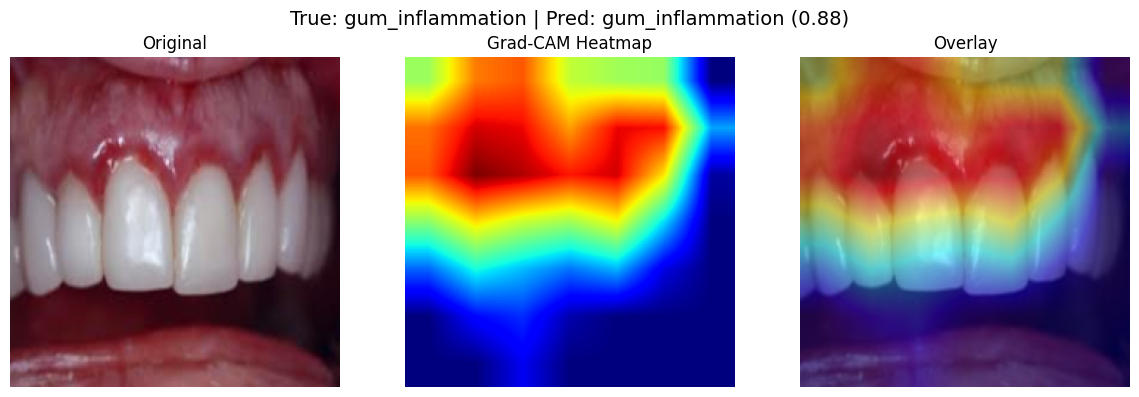

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000000011920929].


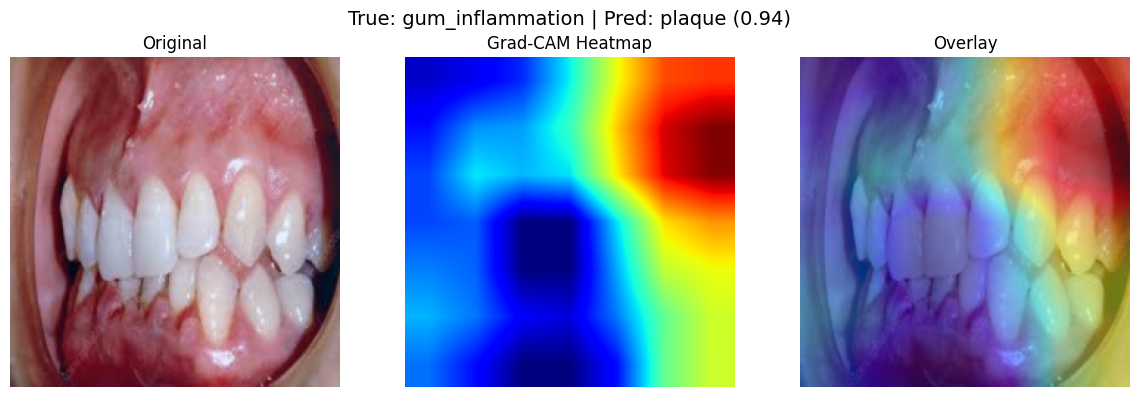

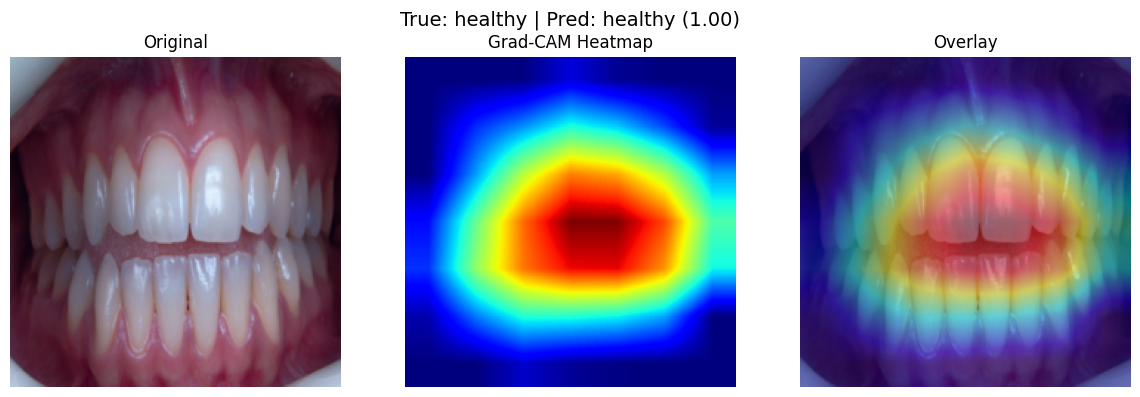

In [10]:
def create_gradcam(model, device):
    """Factory function to create GradCAM with proper layer selection"""
    # Automatically select the target layer for EfficientNet
    target_layer = model.features[-1][0]
    
    class GradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.activations = None
            self.gradients = None
            
            self.forward_handle = target_layer.register_forward_hook(self.save_activation)
            self.backward_handle = target_layer.register_backward_hook(self.save_gradient)
        
        def save_activation(self, module, input, output):
            self.activations = output.detach()
        
        def save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        def generate(self, image_tensor, target_class):
            self.model.zero_grad()
            output = self.model(image_tensor)
            target_score = output[0, target_class]
            target_score.backward()
            
            weights = torch.mean(self.gradients, dim=(2, 3))
            cam = torch.zeros(self.activations.shape[2:], device=self.activations.device)
            
            for i, w in enumerate(weights[0]):
                cam += w * self.activations[0, i]
            
            cam = torch.relu(cam)
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
            
            return cam.cpu().numpy()
        
        def remove_hooks(self):
            self.forward_handle.remove()
            self.backward_handle.remove()
    
    return GradCAM(model, target_layer)

# Usage:
gradcam = create_gradcam(model, DEVICE)

def visualize_gradcam_3panel(image_tensor, cam, title="", alpha=0.45):
    """
    image_tensor: (1, 3, H, W) torch tensor
    cam: (H, W) numpy array from Grad-CAM
    """

    # Prep image
    img = image_tensor[0].detach().cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    H, W = img.shape[:2]

    # Resize CAM
    cam_resized = cv2.resize(cam, (W, H))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # Overlay
    overlay = heatmap * alpha + img * (1 - alpha)

    # Plot
    plt.figure(figsize=(12, 4))
    
    # Original
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    # Heatmap Only
    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(cam_resized, cmap='jet')
    plt.axis("off")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    if title:
        plt.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()

def test_gradcam_real_images():
    """Test Grad-CAM on actual validation images"""
    
    # Get a batch from validation
    images, labels = next(iter(val_loader))
    
    # Create GradCAM instance
    gradcam = create_gradcam(model, DEVICE)
    
    # Test on first few images
    for i in range(min(3, len(images))):  # Test on up to 3 images
        single_image = images[i:i+1].to(DEVICE)  # MOVE TO DEVICE
        true_label = labels[i].item()
        
        # Get model prediction
        with torch.no_grad():
            output = model(single_image)  # Already on device now
            predicted_class = torch.argmax(output, dim=1).item()
            probabilities = torch.softmax(output, dim=1)[0]
        
        # Generate CAM for predicted class
        cam = gradcam.generate(single_image, predicted_class)  # Now same device
        
        # Visualize move back to CPU for visualization
        class_names = train_dataset.classes
        title = f"True: {class_names[true_label]} | Pred: {class_names[predicted_class]} ({probabilities[predicted_class]:.2f})"
        visualize_gradcam_3panel(single_image.cpu(), cam, title)
    
    gradcam.remove_hooks()
 
# Run on real images
test_gradcam_real_images()

# 10. Save Model / Inference Demo 

In [11]:
torch.save(model.state_dict(), "dental_classifier.pth")

In [16]:
from collections import Counter
print(Counter(train_dataset.targets))

Counter({1: 11, 2: 11, 0: 10, 3: 10})
